# Fraud detection in online sales
We have a large dataset pertaining to online e-commerce sales, labeled as fraudulent and non-fraudulent, and our objective is to develop a machine learning solution to classify future sales based on a set of information parameters given.

## Viewing of Data
Initially, we want to observe the shape of data, frequence of the classification feature, so that we can see if we need to fill-in/exclude any data, or take any other preprocessing steps to maintain a balanced approach without over-representation, over-fitting or misleading data.

In [ ]:
import pandas as pd

# load dataset
dataset = pd.read_csv('dataset/merged_dataset.csv')

# shape, types and example
print("Dataset Shape:", dataset.shape)
print("\nData Types:\n", dataset.dtypes)
print("\nFirst Rows:\n", dataset.head())

# categorical feature distribution
print("\nTransaction Fraudulence Data Distribution:\n", dataset['Is.Fraudulent'].value_counts())
print("\nSource Data Distribution:\n", dataset['source'].value_counts())
print("\nBrowser Data Distribution:\n", dataset['browser'].value_counts())
print("\nSex Data Distribution:\n", dataset['sex'].value_counts())
print("\nPayment Method Data Distribution:\n", dataset['Payment.Method'].value_counts())
print("\nProduct Category Data Distribution:\n", dataset['Product.Category'].value_counts())
print("\nDevice Used Data Distribution:\n", dataset['Device.Used'].value_counts())
print("\nAddress Match Distribution:\n", dataset['Address.Match'].value_counts())

Dataset Shape: (300000, 14)

Data Types:
 Transaction.Date       object
Transaction.Amount    float64
Customer.Age            int64
Is.Fraudulent           int64
Account.Age.Days        int64
Transaction.Hour        int64
source                 object
browser                object
sex                    object
Payment.Method         object
Product.Category       object
Quantity                int64
Device.Used            object
Address.Match           int64
dtype: object

First Rows:
       Transaction.Date  Transaction.Amount  Customer.Age  Is.Fraudulent  \
0  2024-02-12 10:05:21              145.98            29              0   
1  2024-01-25 22:24:06              677.62            40              0   
2  2024-03-26 20:32:44              798.63            40              0   
3  2024-01-07 23:14:51              314.65            34              0   
4  2024-01-19 11:01:19              119.80            11              1   

   Account.Age.Days  Transaction.Hour  source  browser sex 

### Conclusions on Viewing
We have a large dataset, with 300000 individual labeled cases, with 13 features, mixed numeric and categoric, which means we will need to encode categorical variables before modeling. <br>
We also have a 13 to 1 distribution of non-fraudulent vs fraudulent cases, which means a highly imbalaced dataset, meaning accuracy will be a misleading metric, and precision, recall and f1-score will be more expressive of the model's peformance. <br>
We might need techniques for handling imbalance, like oversampling, undersampling or class weighting in algorithms. <br>
As for the distributions of categorical data, the source, sex, payment method, product category and device used all follow pretty uniform distributions. While browser and address match over-represent Chrome and 1 respectively.

## Feature Preprocessing
Simple checking (valid values and not-null) and processing of multiple features and cleaning up of the data into a new file. We are clearly shaping our data into a desired state of values. <br>
We also maintain label encoding on Is.Fraudulent, sex and address match because it suits the format and meaning of these categories. <br>
We perform one-hot encoding on source, browser, Payment.Method, Product.Category and Device.Used, in order to not express false order, at the cost of increasing the number of features. <br>
We finally process the raw date into numeric parts fed as numbers into the model.

In [10]:
import pandas as pd

def validate_row(row):
    errors = []

    try:
        pd.to_datetime(row['Transaction.Date'])
    except Exception:
        errors.append('Invalid Transaction.Date')

    if not isinstance(row['Transaction.Amount'], (int, float)) or row['Transaction.Amount'] < 0:
        errors.append('Invalid Transaction.Amount')
    

    if row['Is.Fraudulent'] not in [0, 1]:
        errors.append('Invalid Is.Fraudulent')

    if not isinstance(row['Account.Age.Days'], (int, float)) or not (row['Account.Age.Days'] <= 0 or row['Account.Age.Days'] <= 365):
        errors.appned('Invalid Account.Age.Days')
    
    if not isinstance(row['Transaction.Hour'], (int, float)) or not (0 <= row['Transaction.Hour'] <= 23):
        errors.append('Invalid Transaction.Hour')
    
    if row['source'] not in ['Ads', 'SEO', 'Direct']:
        errors.append('Invalid source')
    
    if row['browser'] not in ['Chrome', 'Safari', 'IE', 'FireFox', 'Opera']:
        errors.append('Invalid source')

    if row['sex'] not in ['M', 'F']:
        errors.append('Invalid sex')

    if row['Payment.Method'] not in ['credit card', 'debit card', 'PayPal', 'bank transfer']:
        errors.append('Invalid Payment.Method')

    if row['Product.Category'] not in ['clothing', 'health & beauty', 'home & garden', 'electronics', 'toys & games']:
        errors.append('Invalid Product.Category')

    if not isinstance(row['Quantity'], (int, float)) or not (1 <= row['Quantity'] <= 5):
        errors.append('Invalid Quantity')

    if row['Device.Used'] not in ['mobile', 'desktop', 'tablet']:
        errors.append('Invalid Device.Used')

    if row['Address.Match'] not in [0, 1]:
        errors.append('Invalid Address.Match')

    return errors

# apply validate_row to all rows
validation_results = dataset.apply(validate_row, axis=1)

# filter into only errors
invalid_rows = dataset[validation_results.apply(lambda x: len(x) > 0)]
error_messages = validation_results[validation_results.apply(lambda x: len(x) > 0)]

# show errors
for (row, errors) in zip(invalid_rows.iterrows(), error_messages):
    index, data = row
    print(f"Row {index} has errors: {errors}")


In [11]:
import pandas as pd 
import numpy as np

# machine learning tool
from sklearn.preprocessing import LabelEncoder

# remove invalid rows
valid_dataset = dataset[validation_results.apply(lambda x: len(x) == 0)].copy()

# label encode 'sex' category
le_sex = LabelEncoder()
valid_dataset['sex'] = le_sex.fit_transform(valid_dataset['sex'])

# select one hot columns
one_hot_columns = ['source', 'browser', 'Payment.Method', 'Product.Category', 'Device.Used']

# perform automatic one-hot encoding through get_dummies
valid_dataset = pd.get_dummies(valid_dataset, columns=one_hot_columns)


# extract transaction date values 
valid_dataset['Transaction.Date'] = pd.to_datetime(valid_dataset['Transaction.Date'], format='mixed')

# create columns for date
valid_dataset['Transaction.Year'] = valid_dataset['Transaction.Date'].dt.year
valid_dataset['Transaction.Month'] = valid_dataset['Transaction.Date'].dt.month
valid_dataset['Transaction.Day'] = valid_dataset['Transaction.Date'].dt.day
valid_dataset['Transaction.Weekday'] = valid_dataset['Transaction.Date'].dt.weekday
# valid_dataset['Transaction.Hour'] = valid_dataset['Transaction.Hour'] # already exists

# perform cyclic enconding so that model understands weekday/hour proximity (e.g. 23 is close to 0)
# for days of week (0-6)
valid_dataset['Weekday_Sin'] = np.sin(2 * np.pi * valid_dataset['Transaction.Weekday'] / 7)
valid_dataset['Weekday_Cos'] = np.cos(2 * np.pi * valid_dataset['Transaction.Weekday'] / 7)

# for hour of day (0-23)
valid_dataset['Hour_Sin'] = np.sin(2 * np.pi * valid_dataset['Transaction.Hour'] / 24)
valid_dataset['Hour_Cos'] = np.cos(2 * np.pi * valid_dataset['Transaction.Hour'] / 24)

# drop redundant column
valid_dataset = valid_dataset.drop(columns=['Transaction.Date'])

# One-hot encode the Transaction.Weekday
valid_dataset = pd.get_dummies(valid_dataset, columns=['Transaction.Weekday'])

# save the prepared
valid_dataset.to_csv('dataset/prepared_dataset.csv', index=False)

## Prepare Data
Now we prepare the data for the model. We split up fraudulence from other characteristics, perform the train/test split, our objective is 80/10/10, as in training/validating/testing, so we use 0.1 test size to extract the 10% for testing. <br>
X represents the data, and y the associated labels.

In [12]:
import pandas as pd
import random

# import machine learning tool
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('dataset/prepared_dataset.csv')

# extract label and features from data
X = dataset.drop('Is.Fraudulent', axis=1)
y = dataset['Is.Fraudulent']

# perform train test split based on random number and keep balance of fraud cases in split
random_number = random.randint(0, 2147483647)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=random_number,
    stratify=y 
)

# Random Forest
Next, we create a RandomForestClassifier model and a pipeline to reach the best ammount of n_estimators and best class weight. <br>
For scoring, we could use recall if we want to catch as many fraudulent cases as possible and do manual reviews later, f1 to strike a balance between these two, or roc_auc to maximize how well the model ranks fraunds over non-frauds. <br>
We shouldn't use accuracy here, because we have an imbalanced dataset and want to catch as many fraudulent cases as possible, not maximize overall accuracy since it can make our model too conservative, or precision, because the few false positives optimization that precision intrinsically does makes it miss more fraudulent cases in exchange for few false positives. <br>
We should choose recall because typically in these types of problems, actually catching all the fraud cases and performing manual filtering of the non-fraud cases tends to be the most useful solution. <br>
In order to maintain a 80/10/10 split, we perform cross validation with 9 partitions to split up the testing/validation data into 10% chunks. <br>
We initially experimented with various values for the `classifier__n_estimators` and the `classifier__class_weight` values, but found that `200` strikes a decent balance of performance training time and returns, and `None` for the class weight is the only one we didn't want to test for because we want to prioritize actually finding fraud cases, and for that we need to make failing predictions on fraud cases more costly.

In [13]:
import random

# import model and pipeline tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, classification_report

# create the pipeline, classifier model of RandomForest
random_number = random.randint(0, 2147483647)
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=random_number))
])

# define hyperparameter search space
param_grid = {
    'classifier__n_estimators': [200],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

# define multiple scorings to be compared
scoring = {
  'recall' : 'recall', # maximizes fraud detection
  'f1' : 'f1', # balance between precision and recall
  'roc_auc' : 'roc_auc' # separation of classes
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=9, # 9-fold cv
    scoring=scoring, # check for all relevant scorings
    refit='recall', # use recall
    verbose=3, # actually get information per fold
    n_jobs=-1 # use all CPU cores
)

grid_search.fit(X_train, y_train)

# best parameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# best estimator 
best_model = grid_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# test thresholds
thresholds = np.linspace(0.1, 0.9, 81)
recalls = []
precisions = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))

# best estimator 
best_model = grid_search.best_estimator_

# find threshold with maximum recall
best_idx = np.argmax(recalls)
best_threshold = thresholds[best_idx]

y_pred = (y_proba >= best_threshold).astype(int)

print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred))

Fitting 9 folds for each of 2 candidates, totalling 18 fits
[CV 9/9] END classifier__class_weight=balanced, classifier__n_estimators=200; f1: (test=0.559) recall: (test=0.391) roc_auc: (test=0.800) total time= 2.7min
[CV 8/9] END classifier__class_weight=balanced_subsample, classifier__n_estimators=200; f1: (test=0.539) recall: (test=0.373) roc_auc: (test=0.794) total time= 1.1min

Best Hyperparameters:
{'classifier__class_weight': 'balanced_subsample', 'classifier__n_estimators': 200}

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27840
           1       0.40      0.55      0.46      2160

    accuracy                           0.91     30000
   macro avg       0.68      0.74      0.71     30000
weighted avg       0.92      0.91      0.91     30000



### Analysis
Our binary classification model has an overall very high precision, since, when it predicts 0 and 1, it is right 95% and 98% of the time. <br>
The recall for 0 and 1 is 1.00 and 0.39, which means that 100% of 0 cases were correctly identified, and 39% of the 1 cases were identified. <br>
The f1-score is 0.98 and 0.56, which indicates that the mix between precision and recall is very good for the 0 label and mediocre for the 1 label. <br>
The dataset is heavily unbalanced, with a lot more legitimate than fraudulent cases, which makes it so that the model becomes better at identifying 0 cases than 1 cases, which is evident from the Classification Report. This iteration of the model is great at guaranteeing lack of fraud, but at identifying fraud it is not so good, only reaching less than half the cases.

## AUC and Confusion Matrix
We use the ROC-Curve and a Confusion Matrix to better visualize these results and the four possible predictions done (FN, TN, FP and TP).

AUC Score: 0.80


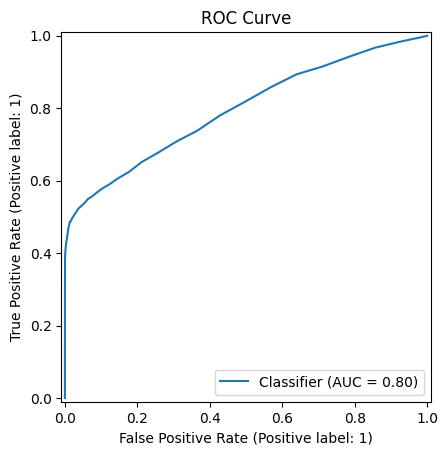

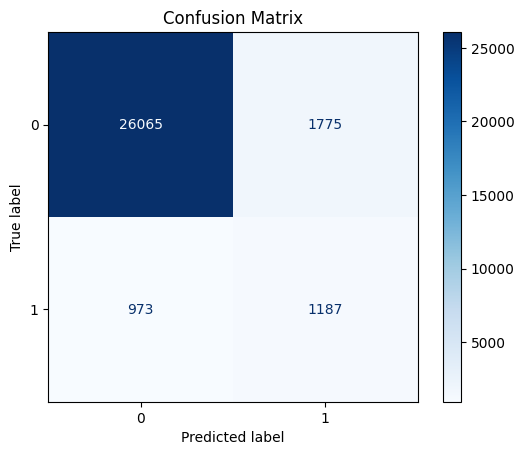

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# AUC score and ROC Curve
# for this we need predicted probabilities for class 1
y_proba = best_model.predict_proba(X_test)[:, 1] 

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.2f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Obter resultados da grelha
results = pd.DataFrame(grid_search.cv_results_)

# Selecionar colunas relevantes
cols = ['param_classifier__class_weight', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']
summary = results[cols].groupby('param_classifier__class_weight').mean().reset_index()

# Mostrar resultados ordenados por recall
print(summary.sort_values(by='mean_test_recall', ascending=False))


  param_classifier__class_weight  mean_test_recall  mean_test_f1  \
1             balanced_subsample          0.379828      0.547484   
0                       balanced          0.379262      0.546928   

   mean_test_roc_auc  
1           0.795762  
0           0.794635  


In [ ]:
# Logistics Regression

# Neural Network (MLP - Multi Layer Perceptron)



In [16]:
import random

# import model and pipeline tools
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, classification_report

# create the pipeline, classifier model of MLPClassifier
random_number = random.randint(0, 2147483647)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=random_number))
])

# define hyperparameter search space
param_grid = {
    'classifier__hidden_layer_sizes': [50,100,200],
    'classifier__activation': ['logistic', 'relu'],
    'classifier__solver': ['adam','sgd'],
    'classifier__alpha':[0.0001,0.001],
    'classifier__learning_rate':['constant','adaptive'],
    'classifier__learning_rate_init':[0.001,0.005,0.01],
    'classifier__max_iter':[100,200,500]
}

# define multiple scorings to be compared
scoring = {
  'recall' : 'recall', # maximizes fraud detection
  'f1' : 'f1', # balance between precision and recall
  'roc_auc' : 'roc_auc' # separation of classes
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=9, # 9-fold cv
    scoring=scoring, # check for all relevant scorings
    refit='recall', # use recall
    verbose=3, # actually get information per fold
    n_jobs=-1 # use all CPU cores
)

grid_search.fit(X_train, y_train)

# best parameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# best estimator 
best_model = grid_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# test thresholds
thresholds = np.linspace(0.1, 0.9, 81)
recalls = []
precisions = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))

# best estimator 
best_model = grid_search.best_estimator_

# find threshold with maximum recall
best_idx = np.argmax(recalls)
best_threshold = thresholds[best_idx]

y_pred = (y_proba >= best_threshold).astype(int)

print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred))

Fitting 9 folds for each of 432 candidates, totalling 3888 fits


/home/avareno/miniconda3/envs/IA/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/avareno/miniconda3/envs/IA/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/avareno/miniconda3/envs/IA/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/avareno/miniconda3/envs/IA/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/avareno/miniconda3/envs/IA/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warning

KeyboardInterrupt: 